In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
class GraphNeuralLayer(layers.Layer):
    def __init__(self, units, activation='relu', use_bias=True, **kwargs):
        super(GraphNeuralLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias

    def build(self, input_shape):
        # input_shape: [(batch, nodes, features), (batch, nodes, nodes)]
        feature_dim = input_shape[0][-1]

        # Message passing weights
        self.W_msg = self.add_weight(
            name='W_msg',
            shape=(feature_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        # Self-connection weights
        self.W_self = self.add_weight(
            name='W_self',
            shape=(feature_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.units,),
                initializer='zeros',
                trainable=True
            )

        super(GraphNeuralLayer, self).build(input_shape)

    def call(self, inputs):
        features, adjacency = inputs

        # Self-connection: process own features
        self_output = tf.matmul(features, self.W_self)

        # Message passing: aggregate neighbor information
        neighbor_messages = tf.matmul(features, self.W_msg)
        aggregated = tf.matmul(adjacency, neighbor_messages)

        # Combine self and neighbor information
        output = self_output + aggregated

        if self.use_bias:
            output = tf.nn.bias_add(output, self.bias)

        return self.activation(output)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias
        }
        base_config = super(GraphNeuralLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
def load_and_preprocess_data():
    try:
        df = pd.read_csv('data.csv')
        print(f"Shape: {df.shape}")

        print(f"Missing values per column: {df.isnull().sum().sum()}")
        if df.isnull().sum().sum() > 0:
            # Fill missing values with median for numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
            print("Missing values filled with median")

        unique_values = df['vital.status'].unique()
        print(f"Unique vital.status values: {unique_values}")

        if set(unique_values).issubset({0, 1}):
            pass  # Already binary
        elif set(unique_values).issubset({'Alive', 'Dead', 'alive', 'dead'}):
            df['vital.status'] = df['vital.status'].str.lower().map({'alive': 0, 'dead': 1})
        elif set(unique_values).issubset({'Living', 'Deceased', 'living', 'deceased'}):
            df['vital.status'] = df['vital.status'].str.lower().map({'living': 0, 'deceased': 1})
        else:
            le = LabelEncoder()
            df['vital.status'] = le.fit_transform(df['vital_status'])
            print(f"Label encoding applied: {dict(zip(le.classes_, le.transform(le.classes_)))}")

        # Check initial label distribution
        print("Initial label distribution:")
        label_counts = df["vital.status"].value_counts()
        print(label_counts)

        # Apply upsampling like in the second project
        df_majority = df[df["vital.status"] == 0]
        df_minority = df[df["vital.status"] == 1]

        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True,
                                         n_samples=len(df_majority),
                                         random_state=42)

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_majority, df_minority_upsampled])

        # Verify the new distribution
        print("After upsampling:")
        label_counts_upsampled = df_balanced["vital.status"].value_counts()
        print(label_counts_upsampled)

        # Separate feature types
        rna_cols = [col for col in df_balanced.columns if col.startswith('rs_')]
        cn_cols = [col for col in df_balanced.columns if col.startswith('cn_')]
        mu_cols = [col for col in df_balanced.columns if col.startswith('mu_')]
        pp_cols = [col for col in df_balanced.columns if col.startswith('pp_')]

        print(f"Feature distribution:")
        print(f"  RNA-seq (rs_): {len(rna_cols)}")
        print(f"  Copy Number (cn_): {len(cn_cols)}")
        print(f"  Mutation (mu_): {len(mu_cols)}")
        print(f"  Protein (pp_): {len(pp_cols)}")
        return df_balanced

    except FileNotFoundError:
        print("Error: data.csv file not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

df = load_and_preprocess_data()

Shape: (705, 1937)
Missing values per column: 0
Unique vital.status values: [0 1]
Initial label distribution:
vital.status
0    611
1     94
Name: count, dtype: int64
After upsampling:
vital.status
0    611
1    611
Name: count, dtype: int64
Feature distribution:
  RNA-seq (rs_): 604
  Copy Number (cn_): 860
  Mutation (mu_): 249
  Protein (pp_): 223


In [7]:
def create_adjacency_matrix(X, method='correlation', threshold=0.7, k_neighbors=10, max_features=200):
    # Reduce feature space to prevent memory issues
    if X.shape[1] > max_features:
        print(f"Reducing features from {X.shape[1]} to {max_features} using variance selection...")
        from sklearn.feature_selection import VarianceThreshold
        selector = VarianceThreshold(threshold=0.01)
        X_reduced = selector.fit_transform(X)

        if X_reduced.shape[1] > max_features:
            # Just take top variance features
            variances = np.var(X, axis=0)
            top_indices = np.argsort(variances)[-max_features:]
            X_reduced = X[:, top_indices]
            feature_indices = top_indices
        else:
            feature_indices = np.arange(X_reduced.shape[1])

        print(f"Final feature count: {X_reduced.shape[1]}")
    else:
        X_reduced = X
        feature_indices = np.arange(X.shape[1])

    n_features = X_reduced.shape[1]

    if method == 'correlation':
        corr_matrix = np.corrcoef(X_reduced.T)
        corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)
        adj_matrix = (np.abs(corr_matrix) > threshold).astype(np.float32)

    else:  # knn method
        from sklearn.neighbors import kneighbors_graph
        adj_matrix = kneighbors_graph(X_reduced.T, n_neighbors=min(k_neighbors, n_features//4),
                                    mode='connectivity', include_self=False)
        adj_matrix = adj_matrix.toarray().astype(np.float32)
        adj_matrix = (adj_matrix + adj_matrix.T) / 2

    adj_matrix += np.eye(n_features, dtype=np.float32)

    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    degree_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(degree_matrix) + 1e-6))
    adj_normalized = degree_inv_sqrt @ adj_matrix @ degree_inv_sqrt

    print(f"Adjacency matrix shape: {adj_normalized.shape}")
    print(f"Number of edges: {np.sum(adj_matrix > 0) // 2}")

    return adj_normalized.astype(np.float32), X_reduced.astype(np.float32), feature_indices

In [9]:
def visualize_data(df, adj_matrix):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0, 0].pie(df['vital.status'].value_counts(),
                   labels=['Alive', 'Deceased'], autopct='%1.1f%%')
    axes[0, 0].set_title('Class Distribution')

    # Feature type distributions
    rna_cols = [col for col in df.columns if col.startswith('rs_')]
    cn_cols = [col for col in df.columns if col.startswith('cn_')]
    mu_cols = [col for col in df.columns if col.startswith('mu_')]
    pp_cols = [col for col in df.columns if col.startswith('pp_')]

    feature_counts = [len(rna_cols), len(cn_cols), len(mu_cols), len(pp_cols)]
    axes[0, 1].bar(['RNA-seq', 'Copy Number', 'Mutation', 'Protein'], feature_counts)
    axes[0, 1].set_title('Feature Types Distribution')
    axes[0, 1].set_ylabel('Number of Features')

    # Sample feature distributions by class
    if len(rna_cols) > 0:
        sample_features = df[rna_cols[:10]].values
        axes[0, 2].boxplot([sample_features[df['vital.status'] == 0].flatten(),
                            sample_features[df['vital.status'] == 1].flatten()],
                           labels=['Alive', 'Deceased'])
        axes[0, 2].set_title('Sample RNA-seq Features by Class')
        axes[0, 2].set_ylabel('Expression Level')
    else:
        axes[0, 2].text(0.5, 0.5, 'No RNA-seq features found', ha='center', va='center')

    # Adjacency matrix heatmap
    sample_adj = adj_matrix[:50, :50]  # Show subset for visibility
    sns.heatmap(sample_adj, cmap='viridis', ax=axes[1, 0])
    axes[1, 0].set_title('Adjacency Matrix (50x50 subset)')

    # Degree distribution
    degrees = np.sum(adj_matrix > 0, axis=1)
    axes[1, 1].hist(degrees, bins=30, alpha=0.7)
    axes[1, 1].set_title('Node Degree Distribution')
    axes[1, 1].set_xlabel('Degree')
    axes[1, 1].set_ylabel('Frequency')

    # PCA visualization
    features = df.drop('vital.status', axis=1).values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)

    colors = ['blue' if x == 0 else 'red' for x in df['vital.status']]
    axes[1, 2].scatter(features_pca[:, 0], features_pca[:, 1], c=colors, alpha=0.6)
    axes[1, 2].set_title(f'PCA Visualization\n(Explained variance: {pca.explained_variance_ratio_.sum():.3f})')
    axes[1, 2].set_xlabel('First Principal Component')
    axes[1, 2].set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()


In [10]:
def build_gnn_model(n_features, num_classes=2):
    feature_input = keras.Input(shape=(n_features, 1), name='features')
    adjacency_input = keras.Input(shape=(n_features, n_features), name='adjacency')

    x = GraphNeuralLayer(512, activation='relu')([feature_input, adjacency_input])
    x = layers.Dropout(0.2)(x)

    x = GraphNeuralLayer(128, activation='relu')([x, adjacency_input])
    x = layers.Dropout(0.2)(x)

    x = GraphNeuralLayer(64, activation='relu')([x, adjacency_input])
    x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(1, activation='sigmoid', name='predictions')(x)

    model = keras.Model(inputs=[feature_input, adjacency_input], outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [11]:
def prepare_graph_data(X, adj_matrix):
    # Reshape features to [batch, nodes, features]
    X_graph = X.reshape(X.shape[0], X.shape[1], 1)

    # Prepare adjacency matrix for each sample in batch
    batch_size = X.shape[0]
    adj_batch = np.tile(adj_matrix[np.newaxis, :, :], (batch_size, 1, 1))

    return X_graph, adj_batch

In [12]:
def train_and_evaluate_model(model, X_train, X_test, adj_matrix, y_train, y_test):
    X_train_graph, adj_train_batch = prepare_graph_data(X_train, adj_matrix)
    X_test_graph, adj_test_batch = prepare_graph_data(X_test, adj_matrix)

    print(f"Training data shape: {X_train_graph.shape}")
    print(f"Adjacency batch shape: {adj_train_batch.shape}")

    callbacks = [
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5),
        keras.callbacks.ModelCheckpoint('bestmodel.h5', save_best_only=True)
    ]

    history = model.fit(
        [X_train_graph, adj_train_batch],
        y_train,
        batch_size=16,
        epochs=100,
        validation_data=([X_test_graph, adj_test_batch], y_test),
        callbacks=callbacks,
        verbose=1
    )

    test_loss, test_accuracy = model.evaluate([X_test_graph, adj_test_batch], y_test, verbose=0)
    print(f"GNN Accuracy: {test_accuracy:.4f}")

    y_pred_proba = model.predict([X_test_graph, adj_test_batch])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score: {auc_score:.4f}")

    return model, history, y_pred_proba, y_pred

In [13]:
def evaluate_model(model, X_test_graph, adj_test_batch, y_test):
    y_pred_proba = model.predict([X_test_graph, adj_test_batch])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy


In [14]:
def plot_results(history, y_test, y_pred_proba, y_pred):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Training history plots
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Alive', 'Deceased'],
                yticklabels=['Alive', 'Deceased'],
                ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    axes[1, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()



In [15]:
def analyze_feature_importance(model, feature_names, X_test_graph, adj_test_batch, feature_indices):
    sample_features = tf.constant(X_test_graph[:1], dtype=tf.float32)
    sample_adj = tf.constant(adj_test_batch[:1], dtype=tf.float32)

    # Compute gradients
    with tf.GradientTape() as tape:
        sample_features_var = tf.Variable(sample_features)
        tape.watch(sample_features_var)
        predictions = model([sample_features_var, sample_adj])

    gradients = tape.gradient(predictions, sample_features_var)

    # Feature importance as absolute gradient values
    feature_importance = np.abs(gradients.numpy()).mean(axis=0).flatten()

    # Map back to original feature names using feature_indices
    original_feature_names = [feature_names[i] for i in feature_indices]

    # Top 20 most important features
    top_indices = np.argsort(feature_importance)[-20:][::-1]
    top_features = [original_feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importance)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance (Absolute Gradient)')
    plt.title('Top 20 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return dict(zip(top_features, top_importance))

In [16]:
X = df.drop(columns=["vital.status"]).values.astype(np.float32)
y = df["vital.status"].values.astype(np.float32)
feature_names = df.drop(columns=["vital.status"]).columns.tolist()

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
adj_matrix, X_reduced, feature_indices = create_adjacency_matrix(
        X_scaled, method='correlation', threshold=0.3, max_features=900
    )

Reducing features from 1936 to 900 using variance selection...
Final feature count: 900
Adjacency matrix shape: (900, 900)
Number of edges: 12117


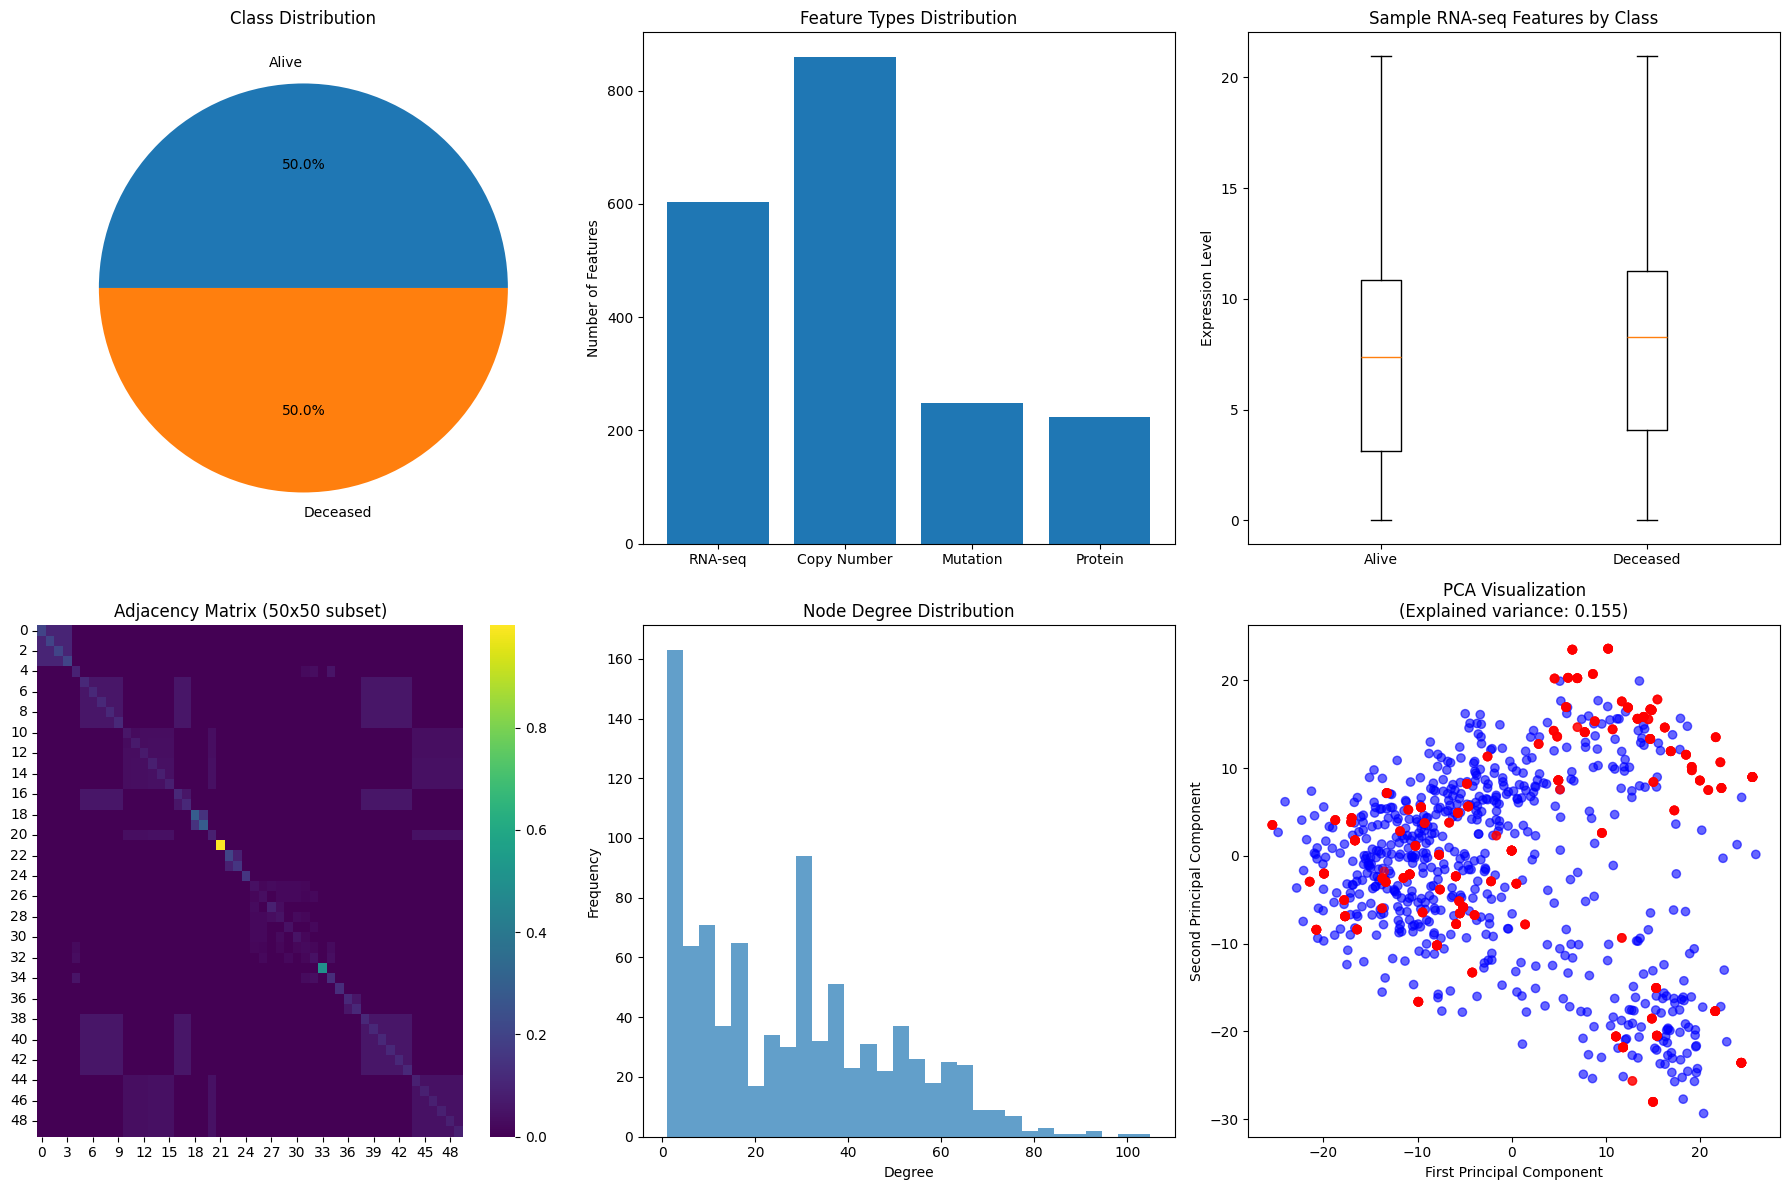

In [19]:
visualize_data(df, adj_matrix)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.2, random_state=42, stratify=y
  )

In [22]:
model = build_gnn_model(n_features=X_train.shape[1])

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 900, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency           │ (None, 900, 900)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer  │ (None, 900, 512)  │      1,536 │ features[0][0],   │
│ (GraphNeuralLayer)  │                   │            │ adjacency[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 900, 512)  │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer… │ (None, 900, 128)  │    131,200 │ dropout[0][0],    │
│ (GraphNeuralLayer)  │                   │            │ adjacency[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 900, 128)  │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer… │ (None, 900, 64)   │     16,448 │ dropout_1[0][0],  │
│ (GraphNeuralLayer)  │                   │            │ adjacency[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 900, 64)   │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_2[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 149,249 (583.00 KB)

 Trainable params: 149,249 (583.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model, history, y_pred_proba, y_pred = train_and_evaluate_model(
        model, X_train, X_test, adj_matrix, y_train, y_test
)

Training data shape: (977, 900, 1)
Adjacency batch shape: (977, 900, 900)
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5088 - loss: 0.6950

62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5085 - loss: 0.6950 - val_accuracy: 0.5020 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4931 - loss: 0.6941

62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4932 - loss: 0.6941 - val_accuracy: 0.5102 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4987 - loss: 0.6932

62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4987 - loss: 0.6932 - val_accuracy: 0.5061 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4798 - loss: 0.6932

62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4801 - loss: 0.6932 - val_accuracy: 0.5020 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5046 - loss: 0.6941 - val_accuracy: 0.5020 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5660 - loss: 0.6912

62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5658 - loss: 0.6912 - val_accuracy: 0.5673 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5196 - loss: 0.6899

62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5196 - loss: 0.6899 - val_accuracy: 0.5837 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5584 - loss: 0.6858 - val_accuracy: 0.5020 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5832 - loss: 0.6838

62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5833 - loss: 0.6837 - val_accuracy: 0.5878 - val_loss: 0.6708 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6202 - loss: 0.6689

62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6202 - loss: 0.6688 - val_accuracy: 0.6000 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6280 - loss: 0.6564

62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6281 - loss: 0.6563 - val_accuracy: 0.6653 - val_loss: 0.6220 - learning_rate: 0.0010
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6662 - loss: 0.6413

62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6661 - loss: 0.6412 - val_accuracy: 0.6694 - val_loss: 0.6048 - learning_rate: 0.0010
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6512 - loss: 0.6365

62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6514 - loss: 0.6364 - val_accuracy: 0.6939 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6748 - loss: 0.6196 - val_accuracy: 0.6490 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6767 - loss: 0.6111

62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6766 - loss: 0.6110 - val_accuracy: 0.6816 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 16/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6989 - loss: 0.5873 - val_accuracy: 0.6653 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 17/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6942 - loss: 0.5893

62/62 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6941 - loss: 0.5893 - val_accuracy: 0.7020 - val_loss: 0.5731 - learning_rate: 0.0010
Epoch 18/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6885 - loss: 0.5918 - val_accuracy: 0.6776 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 19/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6709 - loss: 0.6180 - val_accuracy: 0.6653 - val_loss: 0.5963 - learning_rate: 0.0010
Epoch 20/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6919 - loss: 0.5807 - val_accuracy: 0.6816 - val_loss: 0.5761 - learning_rate: 0.0010
Epoch 21/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6865 - loss: 0.5997

62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6869 - loss: 0.5993 - val_accuracy: 0.6980 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 22/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7253 - loss: 0.5660 - val_accuracy: 0.6857 - val_loss: 0.5780 - learning_rate: 0.0010
Epoch 23/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6826 - loss: 0.5875

62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6829 - loss: 0.5872 - val_accuracy: 0.7143 - val_loss: 0.5462 - learning_rate: 0.0010
Epoch 24/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7179 - loss: 0.5527

62/62 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7180 - loss: 0.5529 - val_accuracy: 0.7061 - val_loss: 0.5430 - learning_rate: 0.0010
Epoch 25/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6902 - loss: 0.5834 - val_accuracy: 0.7143 - val_loss: 0.5434 - learning_rate: 0.0010
Epoch 26/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7293 - loss: 0.5386 - val_accuracy: 0.6449 - val_loss: 0.6131 - learning_rate: 0.0010
Epoch 27/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6991 - loss: 0.5658 - val_accuracy: 0.7061 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 28/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7315 - loss: 0.5569

62/62 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7314 - loss: 0.5568 - val_accuracy: 0.7143 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 29/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7528 - loss: 0.5397 - val_accuracy: 0.6939 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 30/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7289 - loss: 0.5383

62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7288 - loss: 0.5384 - val_accuracy: 0.7347 - val_loss: 0.5218 - learning_rate: 0.0010
Epoch 31/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7074 - loss: 0.5759 - val_accuracy: 0.7306 - val_loss: 0.5238 - learning_rate: 0.0010
Epoch 32/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7480 - loss: 0.5273 - val_accuracy: 0.6571 - val_loss: 0.6082 - learning_rate: 0.0010
Epoch 33/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7214 - loss: 0.5522 - val_accuracy: 0.6939 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 34/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7094 - loss: 0.5565 - val_accuracy: 0.6898 - val_loss: 0.5761 - learning_rate: 0.0010
Epoch 35/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7170 - loss: 0.5554

62/62 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7172 - loss: 0.5553 - val_accuracy: 0.7224 - val_loss: 0.5181 - learning_rate: 0.0010
Epoch 36/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7555 - loss: 0.5330 - val_accuracy: 0.7061 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 37/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7821 - loss: 0.5056 - val_accuracy: 0.7755 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 38/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7157 - loss: 0.5552

62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7163 - loss: 0.5548 - val_accuracy: 0.7551 - val_loss: 0.5080 - learning_rate: 0.0010
Epoch 39/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7662 - loss: 0.5220 - val_accuracy: 0.7388 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 40/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7683 - loss: 0.5131 - val_accuracy: 0.6980 - val_loss: 0.5303 - learning_rate: 0.0010
Epoch 41/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7282 - loss: 0.5433

62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7285 - loss: 0.5430 - val_accuracy: 0.7510 - val_loss: 0.4990 - learning_rate: 0.0010
Epoch 42/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7593 - loss: 0.5273

62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7594 - loss: 0.5270 - val_accuracy: 0.7184 - val_loss: 0.4976 - learning_rate: 0.0010
Epoch 43/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7364 - loss: 0.5170

62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7365 - loss: 0.5171 - val_accuracy: 0.7510 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 44/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7366 - loss: 0.5359 - val_accuracy: 0.7429 - val_loss: 0.5004 - learning_rate: 0.0010
Epoch 45/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7946 - loss: 0.4956 - val_accuracy: 0.7469 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 46/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7450 - loss: 0.5123 - val_accuracy: 0.7143 - val_loss: 0.5150 - learning_rate: 0.0010
Epoch 47/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7404 - loss: 0.5175 - val_accuracy: 0.7469 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 48/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7877 - loss: 0.4758

62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7875 - loss: 0.4759 - val_accuracy: 0.7796 - val_loss: 0.4709 - learning_rate: 0.0010
Epoch 49/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7883 - loss: 0.4717 - val_accuracy: 0.7306 - val_loss: 0.5143 - learning_rate: 0.0010
Epoch 50/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7870 - loss: 0.4766 - val_accuracy: 0.7265 - val_loss: 0.4824 - learning_rate: 0.0010
Epoch 51/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7719 - loss: 0.4884 - val_accuracy: 0.7388 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 52/100
14/62 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7684 - loss: 0.5043